In [1]:
import json
import gzip
import pickle
import re
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, f1_score, precision_recall_fscore_support)
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import joblib


OUTPUT_DIRS = {
    'data': Path('output/data'),
    'models': Path('output/models'),
    'plots': Path('output/plots'),
    'reports': Path('output/reports')
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

plt.style.use('default')
sns.set_palette("husl")

In [2]:
def download_nltk_data():
    """Download required NLTK datasets."""
    required = ['stopwords', 'punkt', 'punkt_tab', 'wordnet', 
                'averaged_perceptron_tagger', 'omw-1.4']
    
    print("Downloading NLTK data...", end=' ')
    for item in required:
        nltk.download(item, quiet=True)
    print("✓")

def save_plot(filename, subdir='plots'):
    """
    Save current plot to output directory and display in notebook.
    
    Args:
        filename: Name of file to save
        subdir: Subdirectory within plots folder
    """
    save_path = OUTPUT_DIRS['plots'] / subdir
    save_path.mkdir(exist_ok=True)
    plt.savefig(save_path / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def load_amazon_reviews(file_path, max_rows=None):
    """
    Load Amazon reviews from compressed JSONL file.
    
    Args:
        file_path: Path to .jsonl.gz file
        max_rows: Optional limit on number of reviews to load
    
    Returns:
        DataFrame containing all review data
    """
    reviews = []
    
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            
            try:
                review = json.loads(line.strip())
                reviews.append(review)
            except json.JSONDecodeError:
                continue
            
            if (i + 1) % 100000 == 0:
                print(f"  Progress: {i + 1:,} reviews", end='\r')
    
    print(f"\n✓ Loaded {len(reviews):,} reviews")
    return pd.DataFrame(reviews)

def clean_text(text):
    """
    Clean and normalize review text.
    
    Args:
        text: Raw review text
    
    Returns:
        Cleaned text string
    """
    if pd.isna(text) or text == '':
        return ""
    
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text):
    """
    Tokenize, remove stopwords, and lemmatize text.
    
    Args:
        text: Cleaned text string
    
    Returns:
        List of processed tokens
    """
    text = clean_text(text)
    
    if not text:
        return []
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    keep_words = {'not', 'no', 'never', 'neither', 'nobody', 'nothing', 
                  'nowhere', 'hardly', 'barely', 'scarcely', "don't", "doesn't",
                  "didn't", "won't", "wouldn't", "shouldn't", "couldn't", "can't"}
    stop_words = stop_words - keep_words
    
    tokens = [w for w in tokens if len(w) > 2 and w not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    
    return tokens

def create_sentiment_label(rating):
    """
    Convert numeric rating to sentiment category.
    
    Args:
        rating: Numeric rating (1-5)
    
    Returns:
        Sentiment label: 'negative', 'neutral', or 'positive'
    """
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

def compute_coherence_values(dictionary, corpus, texts, limit=20, start=5, step=1):
    """
    Compute coherence scores for different numbers of topics.
    
    Args:
        dictionary: Gensim dictionary
        corpus: Gensim corpus
        texts: List of tokenized documents
        limit: Maximum number of topics to test
        start: Minimum number of topics to test
        step: Step size for topic range
    
    Returns:
        Tuple of (model_list, coherence_values)
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print(f"  Testing {num_topics} topics...", end='\r')
        
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            chunksize=2000,
            passes=10,
            alpha='auto',
            eta='auto',
            per_word_topics=True,
            eval_every=None
        )
        
        model_list.append(model)
        
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)
    
    print(f"\n✓ Tested {len(model_list)} topic configurations")
    return model_list, coherence_values

def get_document_topics(lda_model, corpus):
    """
    Extract topic probabilities for each document in corpus.
    
    Args:
        lda_model: Trained LDA model
        corpus: Gensim corpus
    
    Returns:
        DataFrame with topic assignments and probabilities
    """
    all_topics = []
    
    for i, doc_topics in enumerate(lda_model[corpus]):
        if (i + 1) % 50000 == 0:
            print(f"  Processed {i + 1:,} reviews", end='\r')
        
        topic_probs = dict(doc_topics[0])
        
        if topic_probs:
            dominant_topic = max(topic_probs.items(), key=lambda x: x[1])
            
            topic_dict = {
                'dominant_topic': dominant_topic[0],
                'dominant_prob': dominant_topic[1]
            }
            
            for topic_id in range(lda_model.num_topics):
                topic_dict[f'topic_{topic_id}_prob'] = topic_probs.get(topic_id, 0.0)
            
            all_topics.append(topic_dict)
        else:
            all_topics.append({
                'dominant_topic': -1,
                'dominant_prob': 0.0
            })
    
    print("\n✓ Topic assignment complete")
    return pd.DataFrame(all_topics)


In [3]:
def plot_data_exploration(df):
    """
    Generate comprehensive data exploration visualizations.
    
    Args:
        df: DataFrame with review data
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Rating')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    axes[0, 1].hist(df['word_count'], bins=50, color='coral', edgecolor='black')
    axes[0, 1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Words')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_xlim(0, 500)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['year_month'] = df['date'].dt.to_period('M')
    reviews_over_time = df['year_month'].value_counts().sort_index()
    reviews_over_time.plot(ax=axes[1, 0], color='green')
    axes[1, 0].set_title('Reviews Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Number of Reviews')
    axes[1, 0].grid(alpha=0.3)
    
    verified_counts = df['verified_purchase'].value_counts()
    axes[1, 1].pie(verified_counts, labels=['Verified', 'Unverified'], 
                   autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    axes[1, 1].set_title('Verified vs Unverified Purchases', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    save_plot('data_exploration.png', 'exploration')

def plot_topic_coherence(num_topics, coherence_values):
    """
    Plot coherence scores for different numbers of topics.
    
    Args:
        num_topics: List of topic numbers tested
        coherence_values: Corresponding coherence scores
    """
    plt.figure(figsize=(12, 6))
    plt.plot(num_topics, coherence_values, marker='o', linewidth=2, markersize=8)
    plt.xlabel("Number of Topics", fontsize=12)
    plt.ylabel("Coherence Score", fontsize=12)
    plt.title("Topic Coherence Scores", fontsize=14, fontweight='bold')
    plt.xticks(num_topics)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_plot('topic_coherence_scores.png', 'lda')

def plot_confusion_matrix_comparison(y_test, y_pred_before, y_pred_after):
    """
    Compare confusion matrices before and after SMOTE.
    
    Args:
        y_test: True labels
        y_pred_before: Predictions before balancing
        y_pred_after: Predictions after balancing
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    labels = ['negative', 'neutral', 'positive']
    label_names = ['Negative', 'Neutral', 'Positive']
    
    cm_before = confusion_matrix(y_test, y_pred_before, labels=labels)
    sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count'})
    axes[0].set_title('Before SMOTE (Imbalanced)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    cm_after = confusion_matrix(y_test, y_pred_after, labels=labels)
    sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count'})
    axes[1].set_title('After SMOTE (Balanced)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    save_plot('confusion_matrix_comparison.png', 'classification')

def plot_f1_comparison(before_metrics, after_metrics):
    """
    Compare F1 scores before and after SMOTE.
    
    Args:
        before_metrics: Metrics tuple before balancing
        after_metrics: Metrics tuple after balancing
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(3)
    width = 0.35
    
    bars1 = ax.bar(x - width/2, before_metrics[2], width, 
                   label='Before SMOTE', color='lightcoral')
    bars2 = ax.bar(x + width/2, after_metrics[2], width, 
                   label='After SMOTE', color='lightgreen')
    
    ax.set_xlabel('Sentiment Class', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('F1 Score Comparison: Before vs After SMOTE', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    save_plot('f1_score_comparison.png', 'classification')

def plot_aspect_sentiment_distribution(df):
    """
    Visualize sentiment distribution across product aspects.
    
    Args:
        df: DataFrame with topic_label and predicted_sentiment
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    aspect_sentiment_counts = pd.crosstab(df['topic_label'], df['predicted_sentiment'])
    aspect_sentiment_pct = pd.crosstab(df['topic_label'], df['predicted_sentiment'], 
                                       normalize='index') * 100
    
    aspect_sentiment_counts.plot(kind='bar', stacked=False, ax=axes[0], 
                                 color=['#d62728', '#ff7f0e', '#2ca02c'])
    axes[0].set_title('Sentiment Distribution by Aspect (Counts)', 
                      fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Product Aspect', fontsize=12)
    axes[0].set_ylabel('Number of Reviews', fontsize=12)
    axes[0].legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    aspect_sentiment_pct.plot(kind='bar', stacked=False, ax=axes[1],
                              color=['#d62728', '#ff7f0e', '#2ca02c'])
    axes[1].set_title('Sentiment Distribution by Aspect (%)', 
                      fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Product Aspect', fontsize=12)
    axes[1].set_ylabel('Percentage', fontsize=12)
    axes[1].legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    save_plot('aspect_sentiment_distribution.png', 'aspect_analysis')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(aspect_sentiment_counts, annot=True, fmt='d', cmap='RdYlGn',
                cbar_kws={'label': 'Number of Reviews'})
    plt.title('Aspect-Based Sentiment Analysis Heatmap', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Product Aspect', fontsize=12)
    plt.tight_layout()
    save_plot('absa_heatmap.png', 'aspect_analysis')

def generate_aspect_wordclouds(df, aspect_name):
    """
    Generate word clouds for each sentiment within a product aspect.
    
    Args:
        df: DataFrame with processed_text and predicted_sentiment
        aspect_name: Name of the aspect to analyze
    """
    aspect_df = df[df['topic_label'] == aspect_name]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sentiments = ['positive', 'neutral', 'negative']
    colors = ['Greens', 'Blues', 'Reds']
    
    for ax, sentiment, colormap in zip(axes, sentiments, colors):
        text_data = aspect_df[aspect_df['predicted_sentiment'] == sentiment]['processed_text']
        
        if len(text_data) > 0:
            text = ' '.join(text_data.values)
            
            wordcloud = WordCloud(
                width=600, height=400,
                background_color='white',
                colormap=colormap,
                max_words=50,
                relative_scaling=0.5
            ).generate(text)
            
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'{sentiment.capitalize()} ({len(text_data)} reviews)', 
                        fontsize=12, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No reviews', ha='center', va='center')
            ax.set_title(f'{sentiment.capitalize()} (0 reviews)', 
                        fontsize=12, fontweight='bold')
        
        ax.axis('off')
    
    fig.suptitle(f'Word Clouds: {aspect_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    filename = f'wordcloud_{aspect_name.replace(" ", "_").replace("&", "and").lower()}.png'
    save_plot(filename, 'aspect_analysis/wordclouds')

def plot_sentiment_trends(df, aspect_name=None):
    """
    Plot sentiment trends over time for overall or specific aspect.
    
    Args:
        df: DataFrame with year_month and predicted_sentiment
        aspect_name: Optional aspect name to filter by
    """
    if aspect_name:
        df_plot = df[df['topic_label'] == aspect_name]
        title = f'Sentiment Trend: {aspect_name}'
        filename = f'sentiment_trend_{aspect_name.replace(" ", "_").replace("&", "and").lower()}.png'
    else:
        df_plot = df
        title = 'Overall Sentiment Trends Over Time'
        filename = 'sentiment_trend_overall.png'
    
    sentiment_over_time = df_plot.groupby(['year_month', 'predicted_sentiment']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(14, 6))
    sentiment_over_time.plot(kind='line', marker='o', ax=plt.gca(),
                             color=['#d62728', '#ff7f0e', '#2ca02c'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_plot(filename, 'aspect_analysis/trends')

In [4]:
def balance_dataset(X_train, y_train, target_positive=150000, 
                   target_negative=100000, target_neutral=80000):
    """
    Balance dataset using SMOTE oversampling and random undersampling.
    
    Args:
        X_train: Training features
        y_train: Training labels
        target_positive: Target count for positive class
        target_negative: Target count for negative class
        target_neutral: Target count for neutral class
    
    Returns:
        Tuple of (X_balanced, y_balanced)
    """
    print("\n  Applying SMOTE...", end=' ')
    smote = SMOTE(
        sampling_strategy={
            'neutral': target_neutral,
            'negative': target_negative
        },
        random_state=42,
        k_neighbors=5
    )
    X_over, y_over = smote.fit_resample(X_train, y_train)
    print("✓")
    
    print("  Applying undersampling...", end=' ')
    undersample = RandomUnderSampler(
        sampling_strategy={'positive': target_positive},
        random_state=42
    )
    X_balanced, y_balanced = undersample.fit_resample(X_over, y_over)
    print("✓")
    
    return X_balanced, y_balanced

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate multiple Naive Bayes models.
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels
    
    Returns:
        Dictionary with model results
    """
    models = {
        'MultinomialNB': MultinomialNB(alpha=0.1),
        'ComplementNB': ComplementNB(alpha=0.1)
    }
    
    results = {}
    for name, model in models.items():
        print(f"  Training {name}...", end=' ')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name] = {
            'model': model,
            'accuracy': acc,
            'f1': f1,
            'predictions': y_pred
        }
        print(f"✓ (F1: {f1:.4f})")
    
    return results

def tune_hyperparameters(ModelClass, X_train, y_train):
    """
    Perform grid search for optimal hyperparameters.
    
    Args:
        ModelClass: Naive Bayes model class
        X_train: Training features
        y_train: Training labels
    
    Returns:
        Tuned model
    """
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }
    
    print("  Performing grid search...", end=' ')
    grid_search = GridSearchCV(
        ModelClass(),
        param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    print(f"✓ (Best F1: {grid_search.best_score_:.4f})")
    
    return grid_search.best_estimator_

def analyze_aspect(df, aspect_name, n_examples=2):
    """
    Perform detailed analysis of a specific product aspect.
    
    Args:
        df: DataFrame with review data
        aspect_name: Name of aspect to analyze
        n_examples: Number of example reviews to show per sentiment
    
    Returns:
        DataFrame filtered to specified aspect
    """
    print(f"\n{'='*70}")
    print(f"ASPECT: {aspect_name}")
    print(f"{'='*70}")
    
    aspect_df = df[df['topic_label'] == aspect_name].copy()
    
    print(f"\nTotal reviews: {len(aspect_df):,}")
    
    sentiment_counts = aspect_df['predicted_sentiment'].value_counts()
    print("\nSentiment Distribution:")
    for sentiment in ['positive', 'neutral', 'negative']:
        if sentiment in sentiment_counts.index:
            count = sentiment_counts[sentiment]
            pct = (count / len(aspect_df)) * 100
            print(f"  {sentiment.capitalize():<10}: {count:>6,} ({pct:>5.1f}%)")
    
    avg_rating = aspect_df['rating'].mean()
    print(f"\nAverage Rating: {avg_rating:.2f}/5.0")
    
    for sentiment in ['positive', 'negative', 'neutral']:
        examples = aspect_df[aspect_df['predicted_sentiment'] == sentiment].head(n_examples)
        
        if len(examples) > 0:
            print(f"\n{sentiment.upper()} EXAMPLES:")
            for idx, (_, row) in enumerate(examples.iterrows(), 1):
                print(f"\n  [{idx}] Rating: {row['rating']:.0f}/5 | Confidence: {row['dominant_prob']:.2f}")
                text = row['text'] if len(row['text']) <= 200 else row['text'][:200] + "..."
                print(f"      \"{text}\"")
    
    return aspect_df

def save_smote_report(y_train, y_train_balanced, y_test, y_pred_before, y_pred_after):
    """
    Generate and save comprehensive SMOTE improvement report.
    
    Args:
        y_train: Original training labels
        y_train_balanced: Balanced training labels
        y_test: Test labels
        y_pred_before: Predictions before balancing
        y_pred_after: Predictions after balancing
    """
    report_path = OUTPUT_DIRS['reports'] / 'smote_improvement_report.txt'
    
    before_metrics = precision_recall_fscore_support(y_test, y_pred_before, 
                                                       labels=['negative', 'neutral', 'positive'])
    after_metrics = precision_recall_fscore_support(y_test, y_pred_after,
                                                      labels=['negative', 'neutral', 'positive'])
    
    improvement_df = pd.DataFrame({
        'Class': ['Negative', 'Neutral', 'Positive'],
        'F1_Before': before_metrics[2],
        'F1_After': after_metrics[2],
        'F1_Improvement': after_metrics[2] - before_metrics[2],
        'Recall_Before': before_metrics[1],
        'Recall_After': after_metrics[1],
        'Recall_Improvement': after_metrics[1] - before_metrics[1]
    })
    
    with open(report_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("SMOTE IMPROVEMENT REPORT\n")
        f.write("="*70 + "\n\n")
        
        f.write("ORIGINAL DATA DISTRIBUTION:\n")
        f.write(f"  Positive: {(y_train == 'positive').sum():,} ({(y_train == 'positive').mean()*100:.1f}%)\n")
        f.write(f"  Negative: {(y_train == 'negative').sum():,} ({(y_train == 'negative').mean()*100:.1f}%)\n")
        f.write(f"  Neutral: {(y_train == 'neutral').sum():,} ({(y_train == 'neutral').mean()*100:.1f}%)\n\n")
        
        f.write("BALANCED DATA DISTRIBUTION:\n")
        f.write(f"  Positive: {(y_train_balanced == 'positive').sum():,}\n")
        f.write(f"  Negative: {(y_train_balanced == 'negative').sum():,}\n")
        f.write(f"  Neutral: {(y_train_balanced == 'neutral').sum():,}\n\n")
        
        f.write("PERFORMANCE COMPARISON:\n")
        f.write(f"  Before SMOTE - Weighted F1: {f1_score(y_test, y_pred_before, average='weighted'):.4f}\n")
        f.write(f"  After SMOTE  - Weighted F1: {f1_score(y_test, y_pred_after, average='weighted'):.4f}\n\n")
        
        f.write("PER-CLASS F1 IMPROVEMENTS:\n")
        f.write(improvement_df.to_string(index=False))
        f.write("\n\n")
        
        f.write("BEFORE SMOTE:\n")
        f.write(classification_report(y_test, y_pred_before))
        f.write("\n\nAFTER SMOTE:\n")
        f.write(classification_report(y_test, y_pred_after))
    
    print(f"✓ Report saved: {report_path}")

In [5]:
def setup():
    """Download NLTK data and create directory structure."""
    download_nltk_data()
    print("✓ Setup complete\n")

def load_and_explore(file_path='All_Beauty.jsonl.gz'):
    """Load and perform initial exploration of review data."""
    
    print("\nLoading reviews...")
    df = load_amazon_reviews(file_path)
    
    df.to_csv(OUTPUT_DIRS['data'] / 'all_beauty_reviews.csv', index=False)
    print(f"✓ Saved to {OUTPUT_DIRS['data'] / 'all_beauty_reviews.csv'}")
    
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    print("\n" + "-"*70)
    print("DATASET OVERVIEW")
    print("-"*70)
    
    print(f"\nTotal reviews: {len(df):,}")
    print(f"Unique users: {df['user_id'].nunique():,}")
    print(f"Unique products: {df['parent_asin'].nunique():,}")
    print(f"Verified purchases: {df['verified_purchase'].sum():,} ({df['verified_purchase'].mean()*100:.1f}%)")
    
    print("\nRating distribution:")
    print(df['rating'].value_counts().sort_index())
    
    df['text_length'] = df['text'].fillna('').str.len()
    df['word_count'] = df['text'].fillna('').str.split().str.len()
    
    print(f"\nAverage text length: {df['text_length'].mean():.0f} characters")
    print(f"Average word count: {df['word_count'].mean():.0f} words")
    
    print("\nGenerating visualizations...")
    plot_data_exploration(df)
    
    return df


def preprocess_data(df=None):
    """Clean and preprocess review text."""

    if df is None:
        print("\nLoading data...")
        df = pd.read_csv(OUTPUT_DIRS['data'] / 'all_beauty_reviews.csv')
    
    print(f"\nOriginal dataset: {len(df):,} reviews")
    
    df = df[df['text'].notna()].copy()
    print(f"After removing null text: {len(df):,} reviews")
    
    print("\nCleaning text...")
    df['cleaned_text'] = df['text'].apply(clean_text)
    
    print("Tokenizing and lemmatizing...")
    df['tokens'] = df['cleaned_text'].apply(preprocess_text)
    df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    df['token_count'] = df['tokens'].apply(len)
    df = df[df['token_count'] >= 5].copy()
    
    print(f"After filtering short reviews: {len(df):,} reviews")
    
    df['sentiment'] = df['rating'].apply(create_sentiment_label)
    
    df.to_csv(OUTPUT_DIRS['data'] / 'all_beauty_preprocessed.csv', index=False)
    
    print("\n" + "-"*70)
    print("PREPROCESSING COMPLETE")
    print("-"*70)
    print(f"Final dataset: {len(df):,} reviews")
    print("\nSentiment distribution:")
    print(df['sentiment'].value_counts())
    
    print(f"\n✓ Saved to {OUTPUT_DIRS['data'] / 'all_beauty_preprocessed.csv'}")
    
    return df


def find_optimal_topics(df=None, sample_size=100000):
    """Find optimal number of topics using coherence scores."""
    
    if df is None:
        print("\nLoading preprocessed data...")
        df = pd.read_csv(OUTPUT_DIRS['data'] / 'all_beauty_preprocessed.csv')
        df['tokens'] = df['tokens'].apply(eval)
    
    print(f"Dataset size: {len(df):,} reviews")
    
    if len(df) > sample_size:
        print(f"Sampling {sample_size:,} reviews for coherence testing...")
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df.copy()
    
    print("\nCreating dictionary and corpus...")
    dictionary = corpora.Dictionary(df_sample['tokens'])
    
    print(f"Dictionary size before filtering: {len(dictionary):,}")
    
    dictionary.filter_extremes(
        no_below=10,
        no_above=0.5,
        keep_n=5000
    )
    
    print(f"Dictionary size after filtering: {len(dictionary):,}")
    
    corpus = [dictionary.doc2bow(tokens) for tokens in df_sample['tokens']]
    
    dictionary.save(str(OUTPUT_DIRS['models'] / 'beauty_dictionary.dict'))
    with open(OUTPUT_DIRS['models'] / 'beauty_corpus.pkl', 'wb') as f:
        pickle.dump(corpus, f)
    
    print("\n" + "-"*70)
    print("FINDING OPTIMAL NUMBER OF TOPICS")
    print("-"*70)
    
    model_list, coherence_values = compute_coherence_values(
        dictionary=dictionary,
        corpus=corpus,
        texts=df_sample['tokens'].tolist(),
        start=5,
        limit=16,
        step=1
    )
    
    num_topics = list(range(5, 16, 1))
    plot_topic_coherence(num_topics, coherence_values)
    
    optimal_idx = coherence_values.index(max(coherence_values))
    optimal_topics = num_topics[optimal_idx]
    
    print(f"\n✓ Optimal number of topics: {optimal_topics}")
    print(f"✓ Coherence score: {coherence_values[optimal_idx]:.4f}")
    
    results = {
        'num_topics': num_topics,
        'coherence_scores': coherence_values,
        'optimal_topics': optimal_topics
    }
    
    with open(OUTPUT_DIRS['models'] / 'coherence_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    return optimal_topics

def train_final_lda(df=None):
    """Train final LDA model with optimal topics."""
    print("\n" + "-"*70)
    print("TRAINING FINAL LDA MODEL")
    print("-"*70)
    
    if df is None:
        print("\nLoading data...")
        df = pd.read_csv(OUTPUT_DIRS['data'] / 'all_beauty_preprocessed.csv')
        df['tokens'] = df['tokens'].apply(eval)
    
    dictionary = corpora.Dictionary.load(str(OUTPUT_DIRS['models'] / 'beauty_dictionary.dict'))
    
    print("Creating corpus for full dataset...")
    corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]
    
    with open(OUTPUT_DIRS['models'] / 'coherence_results.pkl', 'rb') as f:
        results = pickle.load(f)
        num_topics = results['optimal_topics']
    
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        passes=15,
        iterations=400,
        alpha='auto',
        eta='auto',
        per_word_topics=True,
        eval_every=10
    )
    
    lda_model.save(str(OUTPUT_DIRS['models'] / 'beauty_lda_final.model'))
    
    print("\n" + "-"*70)
    print("DISCOVERED TOPICS")
    print("-"*70)
    
    for idx, topic in lda_model.print_topics(num_topics, num_words=15):
        print(f"\nTopic {idx}:")
        print(f"  {topic}")
    
    topic_labels = {
        0: "General Feedback & Product Experience", 
        1: "Wigs & Hairpieces",                     
        2: "Usage & Duration",                      
        3: "Skin Care & Sensitivity",               
        4: "Product Reviews & Comparisons",         
        5: "Positive Product Reviews",              
        6: "Eye Makeup & Tools",                    
        7: "Product Value & Disappointment",        
        8: "Cosmetics & Shades",                    
        9: "Fragrance & Scent",                     
        10: "Face Masks & Serums",                  
        11: "Oral Care & Toothbrushes",             
        12: "Nail Care & Polish",                   
        13: "Hair Care & Styling",                  
        14: "Product Fit & Size",                   
    }
    
    with open(OUTPUT_DIRS['models'] / 'topic_labels.pkl', 'wb') as f:
        pickle.dump(topic_labels, f)
    
    print("\nCreating interactive visualization...")
    vis = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')
    pyLDAvis.save_html(vis, str(OUTPUT_DIRS['plots'] / 'lda' / 'lda_visualization.html'))
    
    print(f"\n✓ Model saved to {OUTPUT_DIRS['models'] / 'beauty_lda_final.model'}")
    print(f"✓ Visualization saved to {OUTPUT_DIRS['plots'] / 'lda' / 'lda_visualization.html'}")
    
    return lda_model

def assign_topics(df=None):
    """Assign topics to all reviews."""
    print("\n" + "-"*70)
    print("ASSIGNING TOPICS TO REVIEWS")
    print("-"*70)
    
    if df is None:
        print("\nLoading data...")
        df = pd.read_csv(OUTPUT_DIRS['data'] / 'all_beauty_preprocessed.csv')
        df['tokens'] = df['tokens'].apply(eval)
    
    dictionary = corpora.Dictionary.load(str(OUTPUT_DIRS['models'] / 'beauty_dictionary.dict'))
    lda_model = LdaModel.load(str(OUTPUT_DIRS['models'] / 'beauty_lda_final.model'))
    
    with open(OUTPUT_DIRS['models'] / 'topic_labels.pkl', 'rb') as f:
        topic_labels = pickle.load(f)
    
    corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]
    
    print("\nProcessing documents...")
    topics_df = get_document_topics(lda_model, corpus)
    
    df = pd.concat([df.reset_index(drop=True), topics_df], axis=1)
    
    df['topic_label'] = df['dominant_topic'].map(topic_labels)
    df.loc[df['dominant_topic'] == -1, 'topic_label'] = 'Unknown'
    
    df.to_csv(OUTPUT_DIRS['data'] / 'all_beauty_with_topics.csv', index=False)
    
    print("\n" + "-"*70)
    print("TOPIC ASSIGNMENT COMPLETE")
    print("-"*70)
    print("\nTopic distribution:")
    print(df['topic_label'].value_counts())
    
    print(f"\n✓ Saved to {OUTPUT_DIRS['data'] / 'all_beauty_with_topics.csv'}")
    
    return df



def naive_bayes_classification(df=None):
    """Train and evaluate Naive Bayes classifier with SMOTE."""
    
    if df is None:
        print("\nLoading data with topics...")
        df = pd.read_csv(OUTPUT_DIRS['data'] / 'all_beauty_with_topics.csv')
    
    print(f"Dataset size: {len(df):,}")
    print("\nOriginal sentiment distribution:")
    print(df['sentiment'].value_counts())
    
    print("\nCreating TF-IDF features...")
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.7,
        ngram_range=(1, 2),
        sublinear_tf=True
    )
    
    X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
    
    topic_prob_cols = [col for col in df.columns if col.startswith('topic_') and col.endswith('_prob')]
    X_topics = df[topic_prob_cols].fillna(0).values
    
    print("Combining features...")
    X_combined = hstack([X_tfidf, X_topics])
    print(f"Feature shape: {X_combined.shape}")
    
    y = df['sentiment']
    
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_combined, y, df.index,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")
    
    print("\n" + "-"*70)
    print("BALANCING DATASET WITH SMOTE")
    print("-"*70)
    
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
    
    print(f"\nBalanced training set: {len(y_train_balanced):,} samples")
    print(pd.Series(y_train_balanced).value_counts())
    
    print("\n" + "-"*70)
    print("TRAINING MODELS")
    print("-"*70)
    
    results = train_and_evaluate_models(X_train_balanced, y_train_balanced, X_test, y_test)
    
    best_name = max(results, key=lambda k: results[k]['f1'])
    best_model = results[best_name]['model']
    BestModelClass = type(best_model)
    
    print(f"\n✓ Best model: {best_name} (F1: {results[best_name]['f1']:.4f})")
    
    print("\n" + "-"*70)
    print("HYPERPARAMETER TUNING")
    print("-"*70)
    
    tuned_model = tune_hyperparameters(BestModelClass, X_train_balanced, y_train_balanced)
    y_pred_tuned = tuned_model.predict(X_test)
    
    print("\n" + "-"*70)
    print("EVALUATION")
    print("-"*70)
    
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
    
    print(f"\nOverall Performance:")
    print(f"  Accuracy: {accuracy_tuned:.4f}")
    print(f"  Weighted F1: {f1_tuned:.4f}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred_tuned, digits=4))
    
    baseline_model = BestModelClass(alpha=0.1)
    baseline_model.fit(X_train, y_train)
    y_pred_baseline = baseline_model.predict(X_test)
    
    before_metrics = precision_recall_fscore_support(y_test, y_pred_baseline, 
                                                       labels=['negative', 'neutral', 'positive'])
    after_metrics = precision_recall_fscore_support(y_test, y_pred_tuned,
                                                      labels=['negative', 'neutral', 'positive'])
    
    print("\n" + "-"*70)
    print("GENERATING VISUALIZATIONS")
    print("-"*70)
    
    plot_confusion_matrix_comparison(y_test, y_pred_baseline, y_pred_tuned)
    plot_f1_comparison(before_metrics, after_metrics)
    
    print("\n" + "-"*70)
    print("SAVING MODELS")
    print("-"*70)
    
    joblib.dump(tuned_model, OUTPUT_DIRS['models'] / 'naive_bayes_model_balanced.pkl')
    joblib.dump(tfidf_vectorizer, OUTPUT_DIRS['models'] / 'tfidf_vectorizer.pkl')
    
    print(f"✓ Model saved to {OUTPUT_DIRS['models'] / 'naive_bayes_model_balanced.pkl'}")
    print(f"✓ Vectorizer saved to {OUTPUT_DIRS['models'] / 'tfidf_vectorizer.pkl'}")
    
    df_test = df.loc[idx_test].copy()
    df_test['predicted_sentiment'] = y_pred_tuned
    df_test.to_csv(OUTPUT_DIRS['data'] / 'all_beauty_predictions_balanced.csv', index=False)
    
    print(f"✓ Predictions saved to {OUTPUT_DIRS['data'] / 'all_beauty_predictions_balanced.csv'}")
    
    save_smote_report(y_train, y_train_balanced, y_test, y_pred_baseline, y_pred_tuned)
    
    return df_test



def aspect_sentiment_analysis(df=None):
    """Perform aspect-based sentiment analysis."""
    
    if df is None:
        print("\nLoading predictions...")
        df = pd.read_csv(OUTPUT_DIRS['data'] / 'all_beauty_predictions_balanced.csv')
    
    print(f"Total reviews: {len(df):,}")
    
    df = df[df['topic_label'] != 'Unknown'].copy()
    
    aspect_sentiment = pd.crosstab(
        df['topic_label'],
        df['predicted_sentiment'],
        normalize='index'
    ) * 100
    
    print("\n" + "-"*70)
    print("SENTIMENT DISTRIBUTION BY ASPECT")
    print("-"*70)
    print("\n", aspect_sentiment.round(2))
    
    print("\nGenerating visualizations...")
    plot_aspect_sentiment_distribution(df)
    
    aspect_sentiment_counts = pd.crosstab(df['topic_label'], df['predicted_sentiment'])
    
    aspect_summary = pd.DataFrame({
        'Total_Reviews': df.groupby('topic_label').size(),
        'Positive_%': aspect_sentiment['positive'],
        'Neutral_%': aspect_sentiment['neutral'],
        'Negative_%': aspect_sentiment['negative'],
        'Net_Sentiment': aspect_sentiment['positive'] - aspect_sentiment['negative']
    })
    
    aspect_summary = aspect_summary.sort_values('Net_Sentiment', ascending=False)
    
    print("\n" + "-"*70)
    print("ASPECT STRENGTHS & WEAKNESSES")
    print("-"*70)
    
    print("\nSTRONGEST ASPECTS:")
    for aspect in aspect_summary.head(3).index:
        pos_pct = aspect_summary.loc[aspect, 'Positive_%']
        neg_pct = aspect_summary.loc[aspect, 'Negative_%']
        print(f"  • {aspect}: {pos_pct:.1f}% positive, {neg_pct:.1f}% negative")
    
    print("\nWEAKEST ASPECTS:")
    for aspect in aspect_summary.tail(3).index:
        pos_pct = aspect_summary.loc[aspect, 'Positive_%']
        neg_pct = aspect_summary.loc[aspect, 'Negative_%']
        print(f"  • {aspect}: {pos_pct:.1f}% positive, {neg_pct:.1f}% negative")
    
    print("\n" + "-"*70)
    print("DETAILED ASPECT ANALYSIS")
    print("-"*70)
    
    for aspect in aspect_summary.head(2).index:
        analyze_aspect(df, aspect)
    
    print("\n" + "-"*70)
    print("GENERATING WORD CLOUDS")
    print("-"*70)
    
    for aspect in aspect_summary.head(3).index:
        print(f"  Generating word clouds for {aspect}...")
        generate_aspect_wordclouds(df, aspect)
    
    print("\n" + "-"*70)
    print("TEMPORAL ANALYSIS")
    print("-"*70)
    
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['year_month'] = df['date'].dt.to_period('M')
    
    print("\nPlotting overall sentiment trends...")
    plot_sentiment_trends(df)
    
    print("\nPlotting aspect-specific trends...")
    for aspect in aspect_summary.head(2).index:
        print(f"  {aspect}...")
        plot_sentiment_trends(df, aspect)
    
    aspect_summary.to_csv(OUTPUT_DIRS['reports'] / 'aspect_summary.csv')
    print(f"\n✓ Summary saved to {OUTPUT_DIRS['reports'] / 'aspect_summary.csv'}")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)

In [6]:
setup()

✓ Setup complete




Loading reviews...
  Progress: 700,000 reviews
✓ Loaded 701,528 reviews
✓ Saved to output/data/all_beauty_reviews.csv

Dataset shape: (701528, 10)
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

----------------------------------------------------------------------
DATASET OVERVIEW
----------------------------------------------------------------------

Total reviews: 701,528
Unique users: 631,986
Unique products: 112,565
Verified purchases: 634,969 (90.5%)

Rating distribution:
rating
1.0    102080
2.0     43034
3.0     56307
4.0     79381
5.0    420726
Name: count, dtype: int64

Average text length: 173 characters
Average word count: 33 words

Generating visualizations...


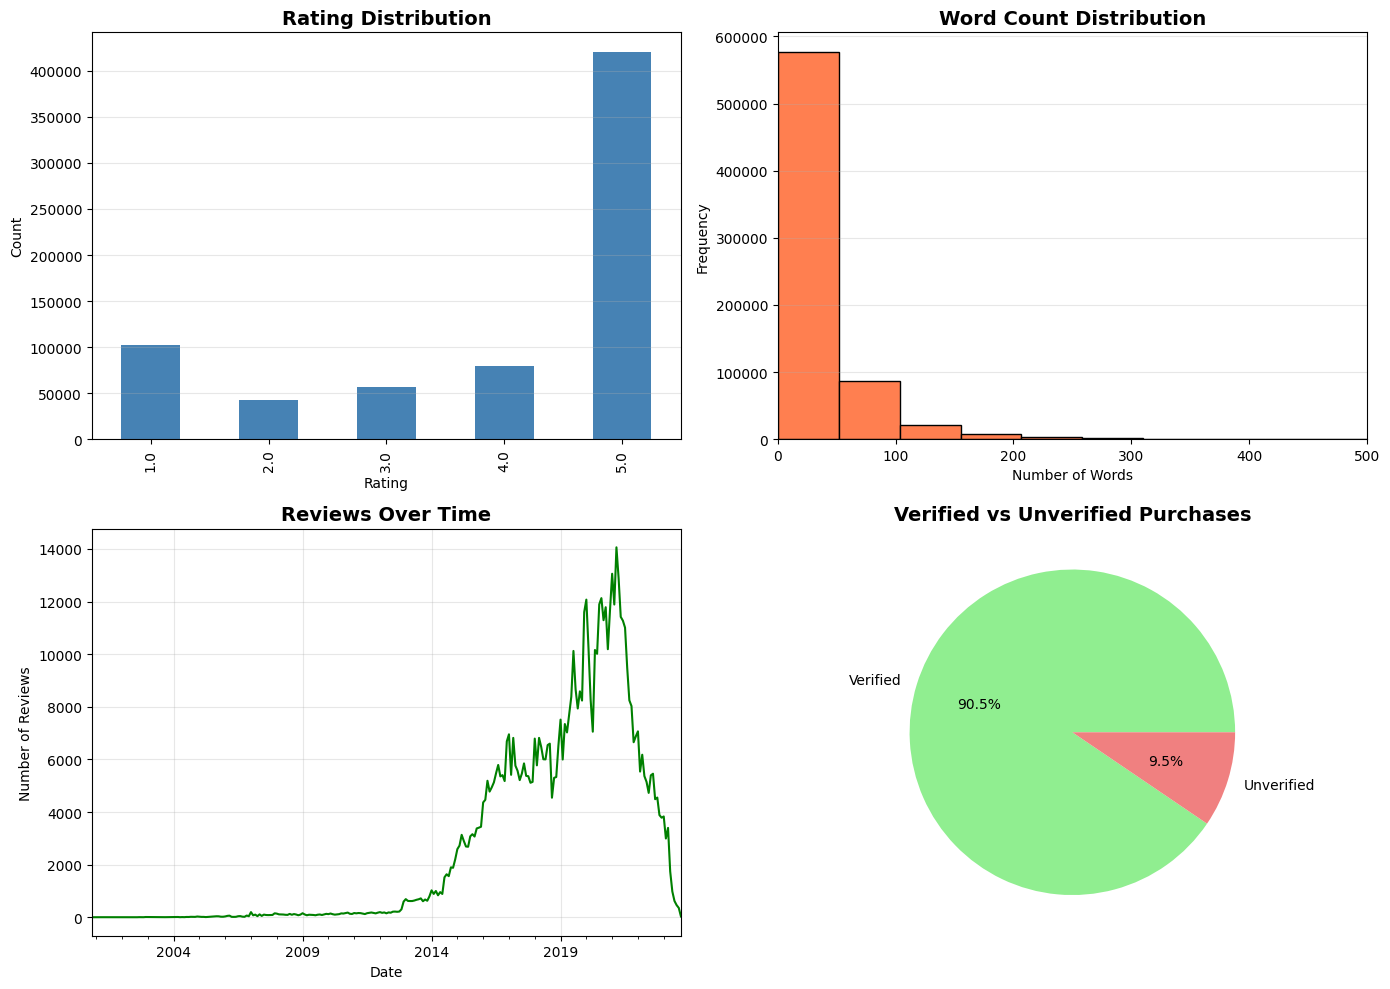

In [7]:
df = load_and_explore('All_Beauty.jsonl.gz')

In [8]:
df = preprocess_data(df)


Original dataset: 701,528 reviews
After removing null text: 701,528 reviews

Cleaning text...
Tokenizing and lemmatizing...
After filtering short reviews: 530,546 reviews

----------------------------------------------------------------------
PREPROCESSING COMPLETE
----------------------------------------------------------------------
Final dataset: 530,546 reviews

Sentiment distribution:
sentiment
positive    367721
negative    116231
neutral      46594
Name: count, dtype: int64

✓ Saved to output/data/all_beauty_preprocessed.csv


Dataset size: 530,546 reviews
Sampling 100,000 reviews for coherence testing...

Creating dictionary and corpus...
Dictionary size before filtering: 36,027
Dictionary size after filtering: 5,000

----------------------------------------------------------------------
FINDING OPTIMAL NUMBER OF TOPICS
----------------------------------------------------------------------
  Testing 15 topics...
✓ Tested 11 topic configurations


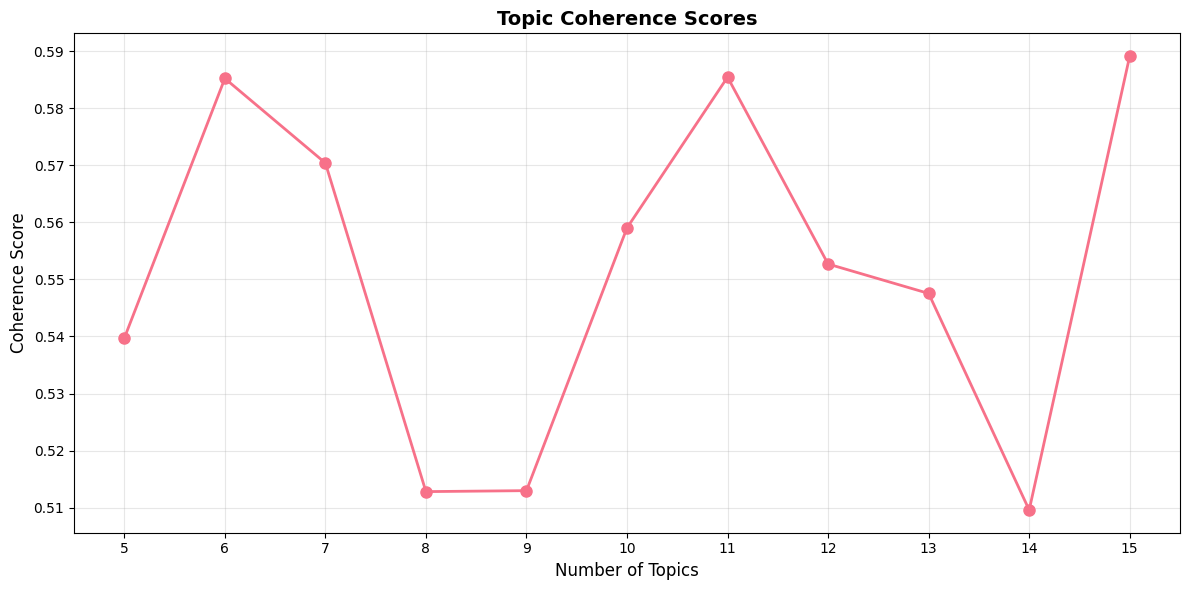


✓ Optimal number of topics: 15
✓ Coherence score: 0.5892


In [9]:
optimal_topics = find_optimal_topics(df)

In [10]:
lda_model = train_final_lda(df)


----------------------------------------------------------------------
TRAINING FINAL LDA MODEL
----------------------------------------------------------------------
Creating corpus for full dataset...

Training LDA model with 15 topics...

----------------------------------------------------------------------
DISCOVERED TOPICS
----------------------------------------------------------------------

Topic 0:
  0.111*"not" + 0.064*"like" + 0.038*"would" + 0.037*"get" + 0.023*"make" + 0.022*"even" + 0.022*"also" + 0.022*"much" + 0.021*"little" + 0.018*"feel" + 0.015*"better" + 0.014*"still" + 0.014*"way" + 0.013*"lot" + 0.012*"need"

Topic 1:
  0.127*"look" + 0.065*"wig" + 0.042*"natural" + 0.036*"wear" + 0.034*"picture" + 0.022*"real" + 0.021*"looked" + 0.020*"black" + 0.017*"length" + 0.017*"style" + 0.016*"compliment" + 0.016*"full" + 0.015*"wearing" + 0.013*"inch" + 0.013*"dark"

Topic 2:
  0.080*"use" + 0.064*"time" + 0.045*"day" + 0.040*"using" + 0.034*"first" + 0.031*"long" + 0.0

In [11]:
df = assign_topics(df)


----------------------------------------------------------------------
ASSIGNING TOPICS TO REVIEWS
----------------------------------------------------------------------

Processing documents...
  Processed 500,000 reviews
✓ Topic assignment complete

----------------------------------------------------------------------
TOPIC ASSIGNMENT COMPLETE
----------------------------------------------------------------------

Topic distribution:
topic_label
General Feedback & Product Experience    218322
Positive Product Reviews                 163061
Product Reviews & Comparisons             85482
Usage & Duration                          26629
Product Fit & Size                        18033
Hair Care & Styling                        4636
Skin Care & Sensitivity                    3520
Wigs & Hairpieces                          2466
Face Masks & Serums                        2285
Product Value & Disappointment             1542
Fragrance & Scent                          1399
Cosmetics & Shades

Dataset size: 530,546

Original sentiment distribution:
sentiment
positive    367721
negative    116231
neutral      46594
Name: count, dtype: int64

Creating TF-IDF features...
Combining features...
Feature shape: (530546, 5015)

Splitting data...
Training set: 424,436 samples
Test set: 106,110 samples

----------------------------------------------------------------------
BALANCING DATASET WITH SMOTE
----------------------------------------------------------------------

  Applying SMOTE... 

/home/varunadhityagb/Syncthing/absa-on-amazon-reviews/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/varunadhityagb/Syncthing/absa-on-amazon-reviews/.venv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


✓
  Applying undersampling... 

/home/varunadhityagb/Syncthing/absa-on-amazon-reviews/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/varunadhityagb/Syncthing/absa-on-amazon-reviews/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/varunadhityagb/Syncthing/absa-on-amazon-reviews/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


✓

Balanced training set: 330,000 samples
sentiment
positive    150000
negative    100000
neutral      80000
Name: count, dtype: int64

----------------------------------------------------------------------
TRAINING MODELS
----------------------------------------------------------------------
  Training MultinomialNB... ✓ (F1: 0.8144)
  Training ComplementNB... ✓ (F1: 0.8046)

✓ Best model: MultinomialNB (F1: 0.8144)

----------------------------------------------------------------------
HYPERPARAMETER TUNING
----------------------------------------------------------------------
  Performing grid search... ✓ (Best F1: 0.7279)

----------------------------------------------------------------------
EVALUATION
----------------------------------------------------------------------

Overall Performance:
  Accuracy: 0.7391
  Weighted F1: 0.7762

Detailed Classification Report:
              precision    recall  f1-score   support

    negative     0.7434    0.6823    0.7116     23246
     ne

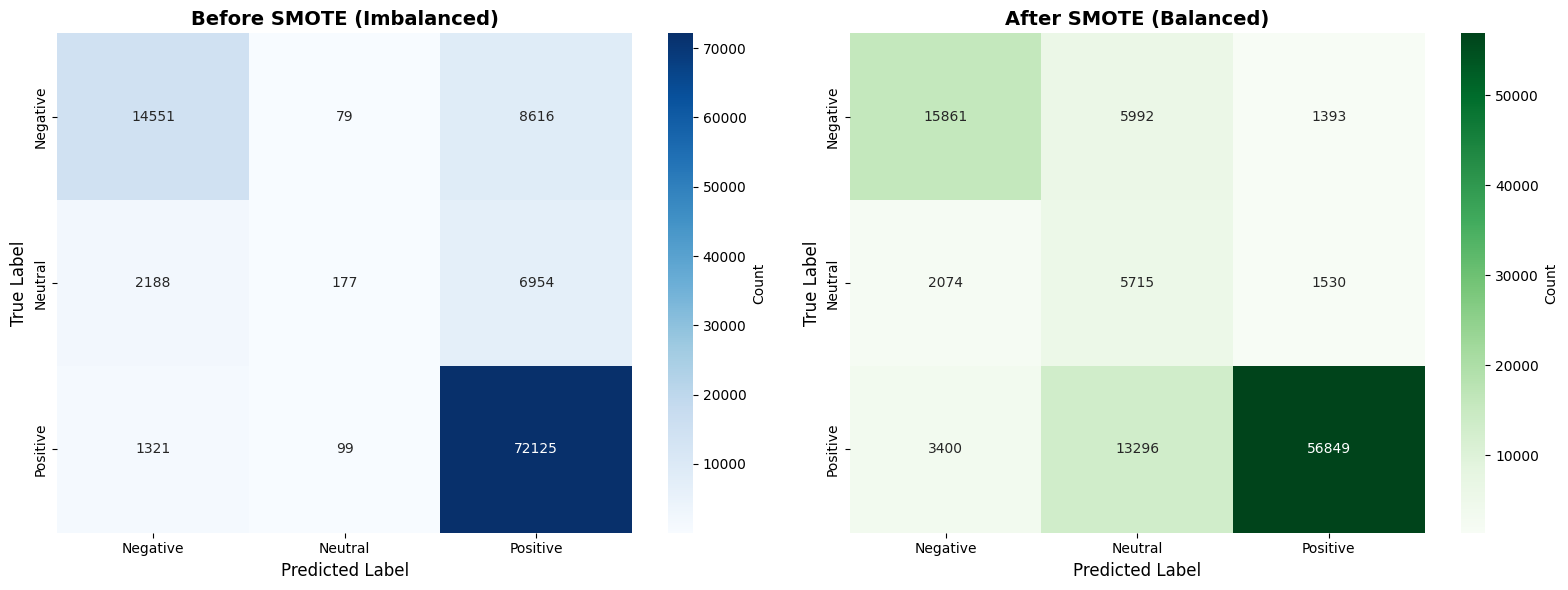

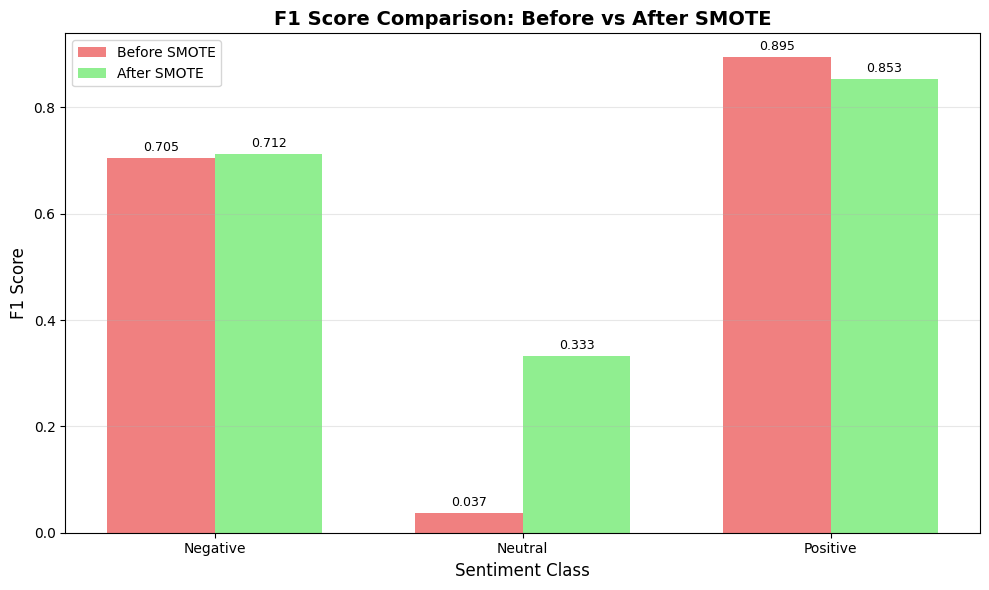


----------------------------------------------------------------------
SAVING MODELS
----------------------------------------------------------------------
✓ Model saved to output/models/naive_bayes_model_balanced.pkl
✓ Vectorizer saved to output/models/tfidf_vectorizer.pkl
✓ Predictions saved to output/data/all_beauty_predictions_balanced.csv
✓ Report saved: output/reports/smote_improvement_report.txt


In [12]:
df_test = naive_bayes_classification(df)

Total reviews: 106,110

----------------------------------------------------------------------
SENTIMENT DISTRIBUTION BY ASPECT
----------------------------------------------------------------------

 predicted_sentiment                    negative  neutral  positive
topic_label                                                       
Cosmetics & Shades                        22.95    48.09     28.96
Eye Makeup & Tools                        24.62    26.15     49.23
Face Masks & Serums                        4.04     8.30     87.66
Fragrance & Scent                          8.42    15.75     75.82
General Feedback & Product Experience     26.92    37.35     35.74
Hair Care & Styling                       15.38    28.01     56.62
Nail Care & Polish                        21.85    35.10     43.05
Oral Care & Toothbrushes                  20.23    18.50     61.27
Positive Product Reviews                   5.25    11.09     83.66
Product Fit & Size                        21.06    44.51     3

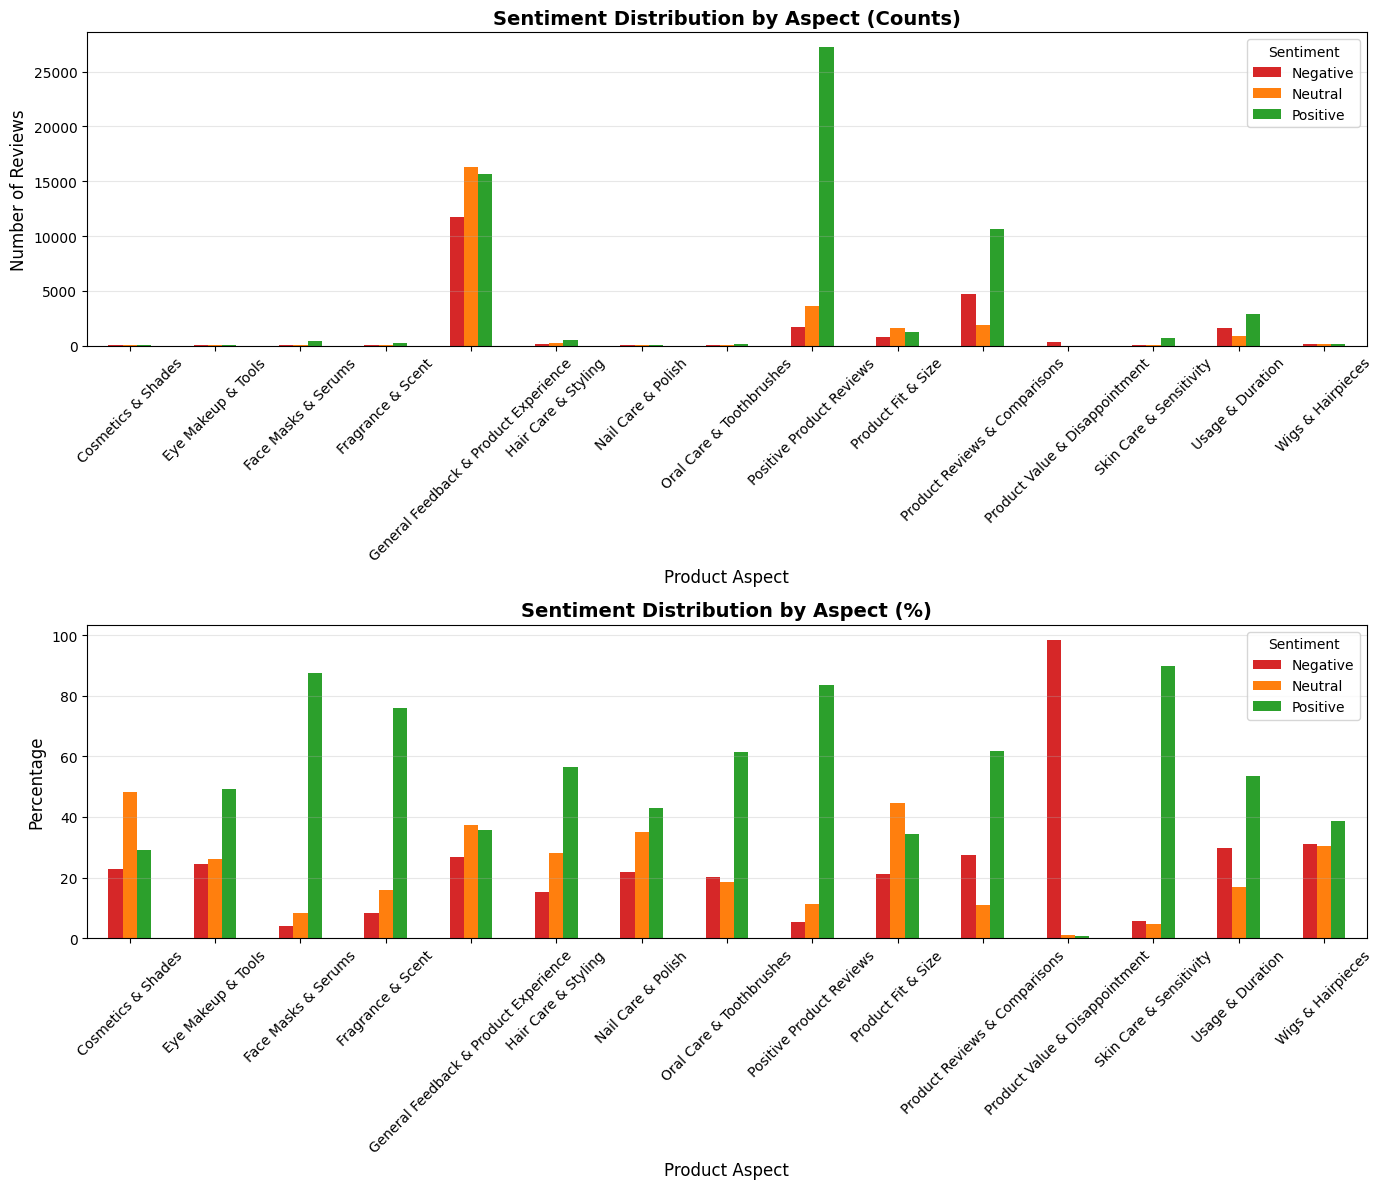

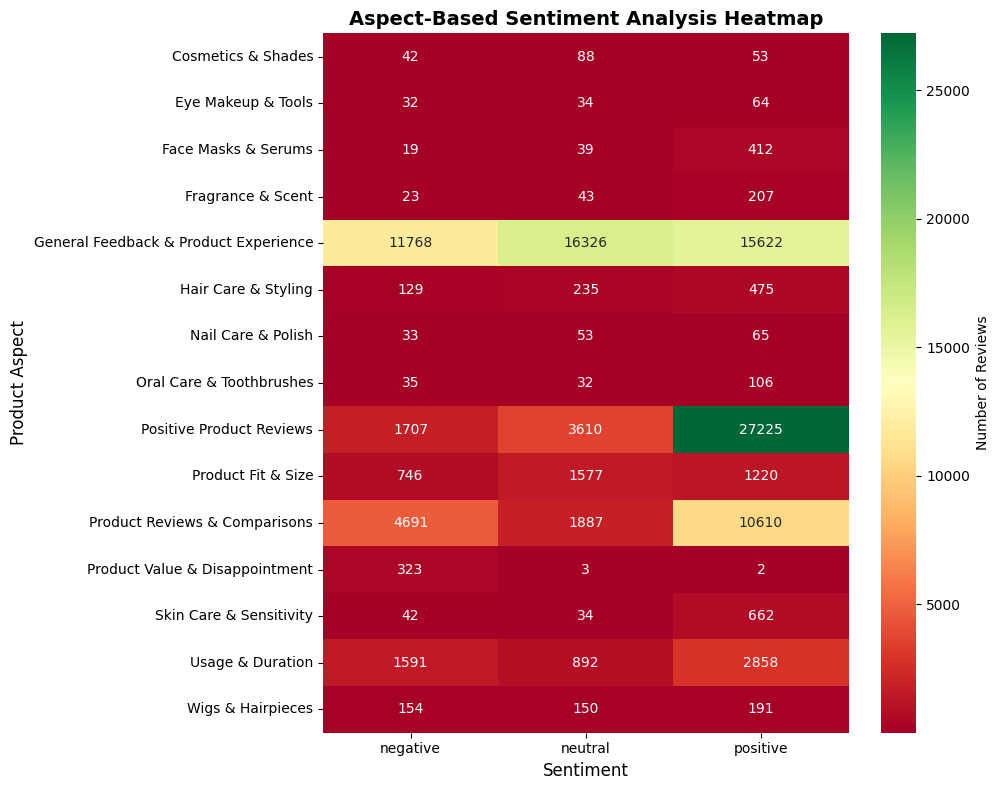


----------------------------------------------------------------------
ASPECT STRENGTHS & WEAKNESSES
----------------------------------------------------------------------

STRONGEST ASPECTS:
  • Skin Care & Sensitivity: 89.7% positive, 5.7% negative
  • Face Masks & Serums: 87.7% positive, 4.0% negative
  • Positive Product Reviews: 83.7% positive, 5.2% negative

WEAKEST ASPECTS:
  • Wigs & Hairpieces: 38.6% positive, 31.1% negative
  • Cosmetics & Shades: 29.0% positive, 23.0% negative
  • Product Value & Disappointment: 0.6% positive, 98.5% negative

----------------------------------------------------------------------
DETAILED ASPECT ANALYSIS
----------------------------------------------------------------------

ASPECT: Skin Care & Sensitivity

Total reviews: 738

Sentiment Distribution:
  Positive  :    662 ( 89.7%)
  Neutral   :     34 (  4.6%)
  Negative  :     42 (  5.7%)

Average Rating: 4.57/5.0

POSITIVE EXAMPLES:

  [1] Rating: 5/5 | Confidence: 0.17
      "I have been u

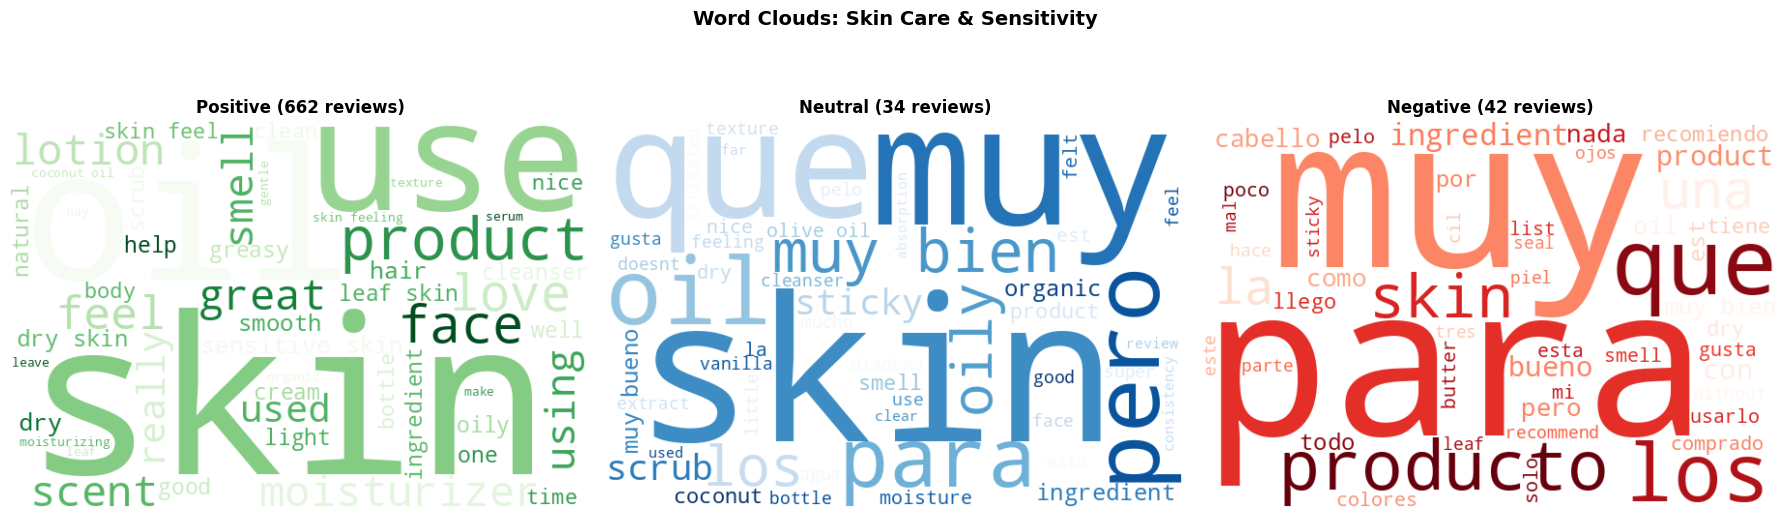

  Generating word clouds for Face Masks & Serums...


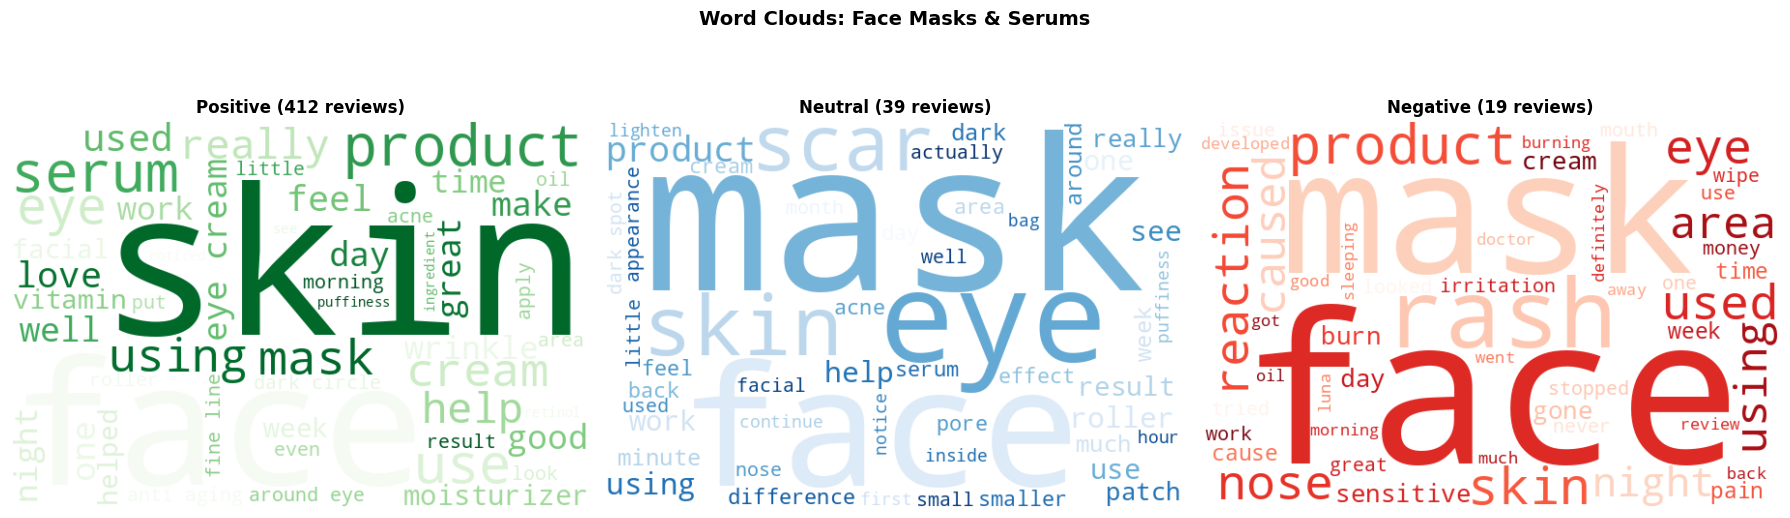

  Generating word clouds for Positive Product Reviews...


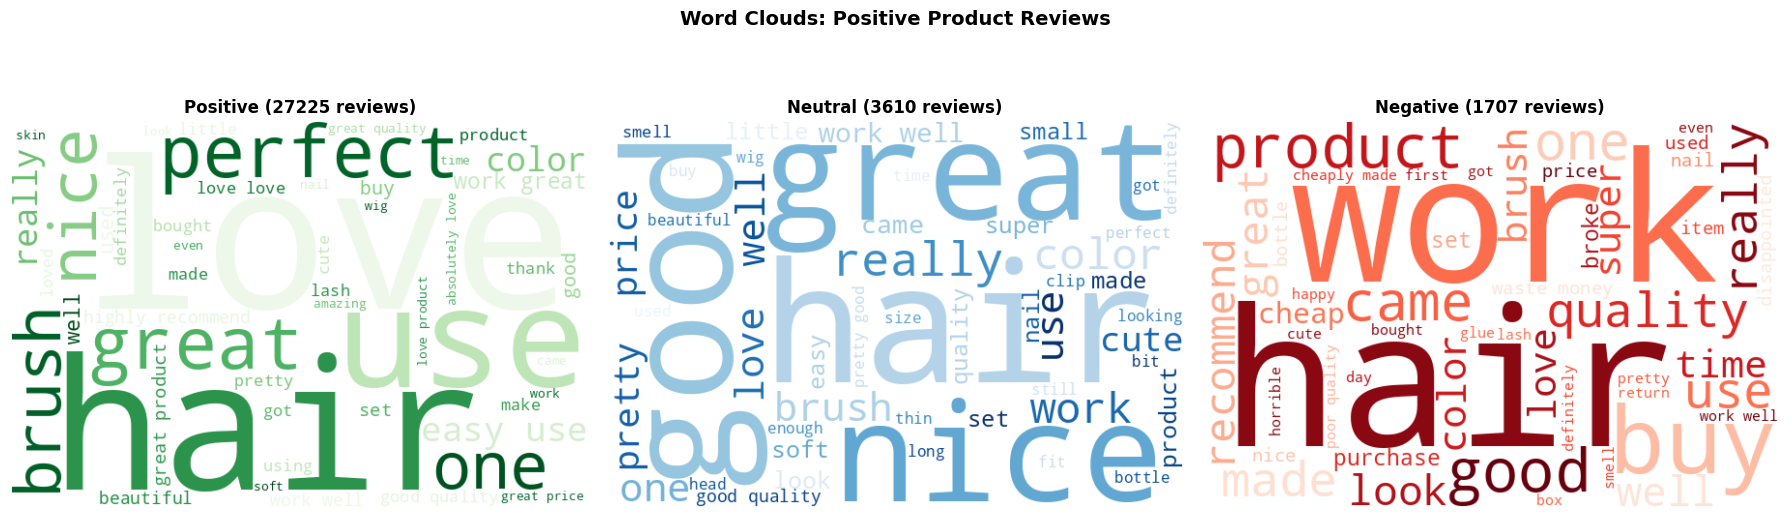


----------------------------------------------------------------------
TEMPORAL ANALYSIS
----------------------------------------------------------------------

Plotting overall sentiment trends...


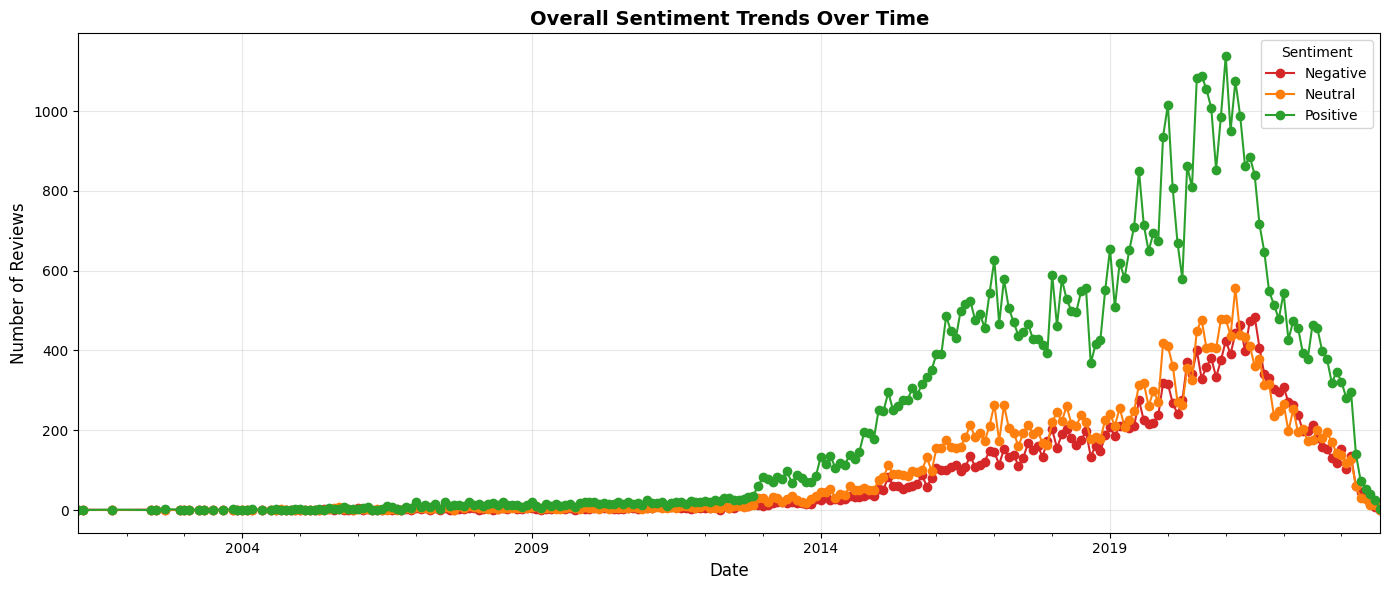


Plotting aspect-specific trends...
  Skin Care & Sensitivity...


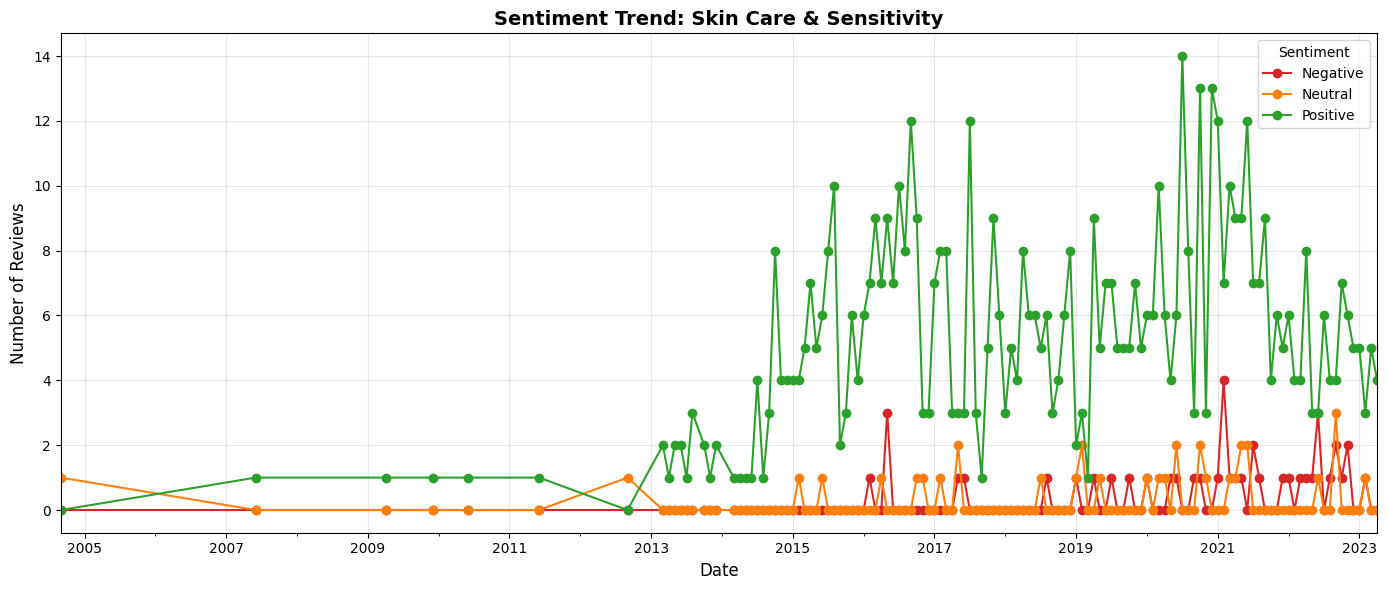

  Face Masks & Serums...


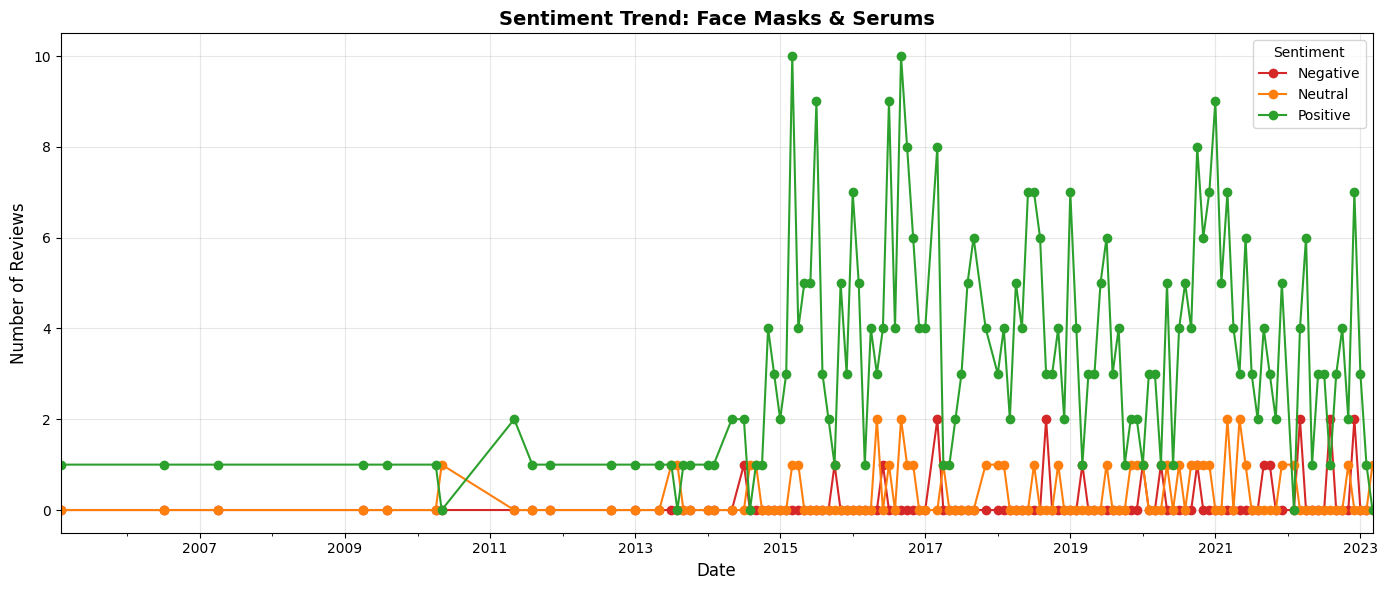


✓ Summary saved to output/reports/aspect_summary.csv

ANALYSIS COMPLETE!


In [13]:
aspect_sentiment_analysis(df_test)